# Descriptor Function Examples

### Introduction

The purpose of this notebook is to demonstrate some examples of the peak descriptors function use. Each cell in this notebook will run from the sample data in this directory

### Installation guidelines

These functions require the following pip installs

```
pip install lmfit
pip install numpy
pip install pandas
pip install peakutils
pip install scipy
```
### Import statements

In [1]:
import descriptors
import chachifuncs as ccf

### LMfit

lmfit is an open-source fitting platform based on `scipy.optimize.leastsq`. It uses a Levenberg-Marquart algorithm with numerically-calculated derivatives from MINPACK's lmdif function. For our use case. We needed to fit a mixture of Pseudo-Voight distributions with a 4th degree polynomial background. The Pseudo-Voight distribution has the following form:

$$f_v(x,A,\mu,\sigma,\alpha)=\frac{(1−\alpha)A}{\sigma_g \sqrt{2 \pi}}\exp{[−{(x− \mu)}_2/2 {\sigma_g}^2]}+\frac{\alpha A}{\pi}[\frac{\sigma}{{(x-\mu)}^2 + \sigma^2}]$$
$$\sigma_g = \sigma/\sqrt{2 \ln{2}}$$

In this model $A$ is the amplitude of the peak, $\mu$ is the center of the distribution, $\sigma$ and $\alpha$ is the fraction of Lorenzian character.

This function was used to develop and fit $f(x)$ to the following, not linear model:

$$\hat{f}(x) = \sum_{i=0}^{3}\hat{c}_i x^i + \sum_{j=1}^{n}\hat{f}_{vj}(x,\hat{A}_j,\hat{\mu}_j,\hat{\sigma}_j,\hat{\alpha}_j)$$

Where $n$ is the number of peaks determined by the peak fitting function `peak_finder`. The peak finding function uses `peakutils` package.

### Descriptors for ML
The following descriptors were extracted from the each fit for use in the machine leaning component of this package.

Polynomial coefficients:
$$c_0, c_1, c_2, c_3$$

For each peak $j$, the following parameters were used:

$\hat{\mu}_j = $ Peak center

$f(\hat{\mu}_j) = $ Peak height

$\hat{\sigma}_j = $ Peak standard deviation

### Fitting Error analysis

Functional form of reduced chi squared:

$$\chi_{\nu}^2 = \sum_{i=0}^{n}\frac{{(\hat{f}(x_i)-f(x_i))}^2}{(n-N_{pars})}$$

Functional form of Bayesian infromation criterion (BIC):
$$BIC = n \ln{(\chi^2/n)} + \ln{(n)} N_{pars}$$

functional form of Akaike information criterion (AIC):

$$AIC = n \ln{(\chi^2/n)} + 2 N_{pars}$$

## Fitting Class Examples

The examples below are codes used to develop the `fitting` class.

### File imports with chachifuncs

The following code was used to import a single cycle of data to this jupyter notebook

Text(0,0.5,'dQ/dV')

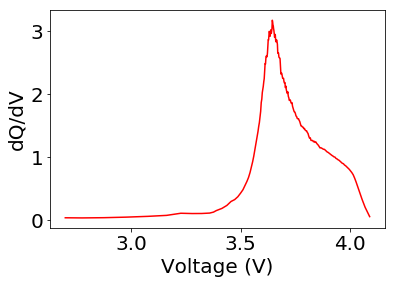

In [6]:
import chachifuncs as ccf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#reads a single excel spreadsheet into Jupyter
#need to reset to cycle 10
testdf = pd.read_excel('data/Clean_Separated_Cycles/CS2_33_12_23_10-Cycle2Clean.xlsx')

#separates charge and discharge cycles using chachifuncs
charge, discharge = ccf.sep_char_dis(testdf)

#converts charge data to a pandas dataframe
sigx_bot = pd.to_numeric(discharge['Voltage(V)']).as_matrix()
sigy_bot = -pd.to_numeric(discharge['Smoothed_dQ/dV']).as_matrix()

plt.rcParams.update({'font.size':20})
#fig, ax = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(sigx_bot, sigy_bot, 'r')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')

### Sub Component Examples

#### PeakUtils Peak Finder

This function uses the PeakUtils package to find all of the peaks in the dataset displayed above. An additional function `fitters.cd_dataframe` is used to flip the y data of the discharge curves and convert the pandas series used in `fitters.descriptor_func` to numpy arrays.

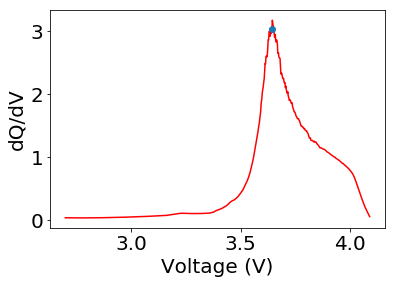

In [2]:
import peakutils
import scipy.signal

#applies additional level of smoothing to prevent indexing of false peaks
sigy_smooth = scipy.signal.savgol_filter(sigy_bot, 25, 3)

#determines indexes of peaks in the dataset
i = peakutils.indexes(sigy_smooth, thres=.3/max(sigy_bot), min_dist=9)

#plots data
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot, sigy_bot, 'r')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.plot(sigx_bot[i], sigy_bot[i], 'o')

#### lmfit model generation

The following cell creates model objects for use in the final fitting of the dQ/dV curve. 

In [3]:
from lmfit import models

#creates a polynomial fitting object
mod = models.PolynomialModel(4)

#sets polynomial parameters based on a
#guess of a polynomial fit to the data with no peaks
par = mod.guess(sigy_bot, x=sigx_bot)

#iterates over all peak indices
for index in i:
    
    #generates unique parameter strings based on index of peak
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    #generates a pseudo voigt fitting model
    gaus_loop = models.PseudoVoigtModel(prefix=comb)
    par.update(gaus_loop.make_params())
    
    #uses unique parameter strings to generate parameters with initial guesses
    #in this model, the center of the peak is locked at the peak location determined from PeakUtils
    par[comb+cent].set(sigx_bot[index], vary=False)
    
    #the other initial parameters were found by trial and error
    par[comb+sig].set(0.01)
    par[comb+amp].set(.05, min=0)
    par[comb+fract].set(.5)
    
    #adds each pseudo voigt model to the polynomial model
    mod = mod + gaus_loop

#### Final fit generation

The following code uses the `mod` and `par` objects found above to determine the final fit to the battery cycle. The execution of this model is performed below:

[[Model]]
    (Model(polynomial) + Model(pvoigt, prefix='a127_'))
[[Fit Statistics]]
    # function evals   = 399
    # data points      = 190
    # variables        = 8
    chi-square         = 1.924
    reduced chi-square = 0.011
    Akaike info crit   = -856.601
    Bayesian info crit = -830.625
[[Variables]]
    c0:              -1598.42698 +/- 107.7335 (6.74%) (init= 1535.683)
    c1:               1955.76707 +/- 125.8694 (6.44%) (init=-1696.265)
    c2:              -890.933528 +/- 54.74614 (6.14%) (init= 689.2991)
    c3:               179.053362 +/- 10.51267 (5.87%) (init=-121.9478)
    c4:              -13.3925248 +/- 0.752589 (5.62%) (init= 7.913243)
    a127_fraction:    1.19144191 +/- 0.058960 (4.95%) (init= 0.5)
    a127_sigma:       0.06452554 +/- 0.002313 (3.59%) (init= 0.01)
    a127_center:      3.643138 (fixed)
    a127_amplitude:   0.57677534 +/- 0.049520 (8.59%) (init= 0.05)
    a127_fwhm:        0.12905108 +/- 0.004627 (3.59%)  == '2.0000000*a127_sigma'
[[Correlati

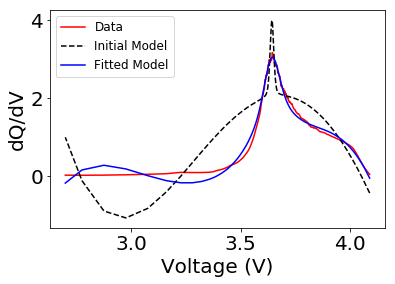

In [4]:
#evaluates fit using the default scipy.leastsquare method
model = mod.fit(sigy_bot, par, x=sigx_bot)

#generates a fit report containing fit parameters as well as error values
print(model.fit_report(min_correl=0.5))

#plots data
plt.plot(sigx_bot, sigy_bot, 'r')
plt.plot(sigx_bot, model.init_fit, 'k--')
plt.plot(sigx_bot, model.best_fit, 'b-')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.legend(['Data', 'Initial Model', 'Fitted Model'], loc=2, fontsize=12)

#### Dictionary Organization

Once the model is finished, the generated model is processed into a dictionary of descriptors. Here is an example of code:

In [5]:
import descriptors
import numpy as np
coefficients = []

for k in np.arange(4):
#key calculation for coefficient collection
    coef = 'c' + str(k)
    #extracting coefficients from model object
    coefficients.append(model.best_values[coef])

#creates a dictionary of coefficients
desc = {'coefficients': coefficients}
if len(i) > 0:
    #generates numpy array for peak calculation
    sigx, sigy = descriptors.fitters.cd_dataframe(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')
    
#determines peak location and height locations from raw data
    desc.update({'peakLocation(V)': sigx[i].tolist(), 'peakHeight(dQdV)': sigy[i].tolist()})
    #initiates loop to extract 
    sig = []
    for index in i:
        #determines appropriate string to call standard deviation object from model
        center, sigma, amplitude, fraction, comb = descriptors.fitters.label_gen(index)
        sig.append(model.best_values[sigma])

    #updates dictionary with sigma key and object
    desc.update({'peakSIGMA': sig})
#adds keys for the error parameters of each fit
desc.update({'errorParams': [model.aic, model.bic, model.redchi]})
    
desc

{'coefficients': [-1598.4269803962648,
  1955.767076728213,
  -890.9335287031297,
  179.0533623840819],
 'errorParams': [-856.6011819365218, -830.6249893592379, 0.010571216301928164],
 'peakHeight(dQdV)': [1.448182915541478],
 'peakLocation(V)': [4.113237380981445],
 'peakSIGMA': [0.0645255445500641]}

## Process Class

These functions execute the lmfit peak fitting function and properly organize the pandas dataframe of descriptors. This pandas dataframe has the following form.

In [7]:
pd.DataFrame(columns=['names', 'ch_0', 'ch_1', '...', 'ch_18', 'dc_0', 'dc_1', '...', 'dc_18'])

,names,ch_0,ch_1,...,ch_18,dc_0,dc_1,...,dc_18


### Process class work flow

This call graph was generated on a set of two batteries with 16 cycles total. It shows the structure of the `descriptors` package when `ML_generate` is called.

![Images/Function_flow.png](Images/Function_flow.png)

This figure was generated using the package `pycallgraph`. It can be found at the following GitHub repository: https://github.com/gak/pycallgraph/#python-call-graph

It is installable with the following lines in a python terminal:
```
pip install pycallgraph
pip install graphviz
```
The code below demonstrates a successful run of the overall `ML_generator` function while generating a class work flow diagram for the package.

In [1]:
from pycallgraph import PyCallGraph
from pycallgraph.output import GraphvizOutput
import descriptors

graphviz = GraphvizOutput(output_file='descriptors_class.png')

with PyCallGraph(output=graphviz):
    descriptors.ML_generate('dataClean_Separated_Cycles')

Successfully extracted all battery names for c
Fitting battery: 7_24_13_1C_Cycle c
Cycle 51 in battery 7_24_13_1C_Cycle had fewer than 10 datapoints and was removed from the dataset.
Fitting battery: CS2_33_10_04_10 c
Fitting battery: CS2_33_12_23_10 c
Successfully extracted all battery names for d
Fitting battery: 7_24_13_1C_Cycle d
Cycle 51 in battery 7_24_13_1C_Cycle had fewer than 10 datapoints and was removed from the dataset.
Fitting battery: CS2_33_10_04_10 d
Fitting battery: CS2_33_12_23_10 d


# Final Output from Above Call

In [2]:
import pandas as pd
pd.read_excel('describe.xlsx')

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8,ch_9,...,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_AIC,dc_BIC,dc_red_chi_squared
0,9833.408526,-11632.447504,5128.173261,-998.438436,3.437595,13.739930,0.024292,0.000000,0.000000,0.000000,...,468.883904,3.169594,15.037665,0.022785,0.000000,0.000000,0.000000,87.571445,107.206223,2.534166
0,15489.181555,-15659.988501,5910.751774,-987.064593,3.802538,1.939364,0.016308,3.912368,4.090270,0.028114,...,146.184351,3.662901,4.000374,0.054731,3.595998,1.682794,0.010188,-833.146573,-795.279978,0.025910
1,19099.264665,-19531.865696,7463.508047,-1263.052905,3.802862,1.971420,0.014865,3.909938,4.521553,0.024031,...,-129526.121267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-216.678671,-209.842192,0.000487
0,110224.232910,-112814.922462,43225.477235,-7348.691072,3.932779,2.718488,0.026221,3.967121,2.716692,0.030367,...,11.665265,3.646216,3.207695,0.055360,0.000000,0.000000,0.000000,-704.716192,-678.698005,0.023979
1,136860.990486,-138517.265342,52514.967101,-8839.128748,3.934885,2.585210,0.032319,3.959669,2.719895,0.050882,...,9.453748,3.643138,3.039284,0.055324,0.000000,0.000000,0.000000,-684.012883,-658.036691,0.026219
2,123169.886012,-124600.875574,47214.296774,-7942.455040,3.929377,2.592342,0.025312,3.952866,2.591363,0.000338,...,48.763451,3.651075,3.173895,0.058016,0.000000,0.000000,0.000000,-771.540081,-745.521893,0.016900


## Descriptor Key

the 'ch_' prefix is for the charge descriptors and will be used in this table as 'pref':

DataFrame Entry | Descriptors
------|------
pref_0 to pref_3 | polynomial coefficient in order of degree
pref_4, 7, 10, ... | peak location (V)
pref_5, 8, 11, ... | peak height (dQ/dV)
pref_6, 9, 12, ... | peak $\sigma$

## Error Analysis

This example is meant to demonstrate the accuracy of the peak fitting algorithm. The reduced Chi squared, the Bayesian information criterion (BIC) and the Akaike information criterion (AIC) are all minimized by a proper fit. These plots show that there is some noise for fit quality, but overall, the peak fitting quality is maintained across a particular battery. Comparisons between two batteries show that the mean error of the fit will vary from battery to battery. Reducing this variation will be a subject of future work on this package.

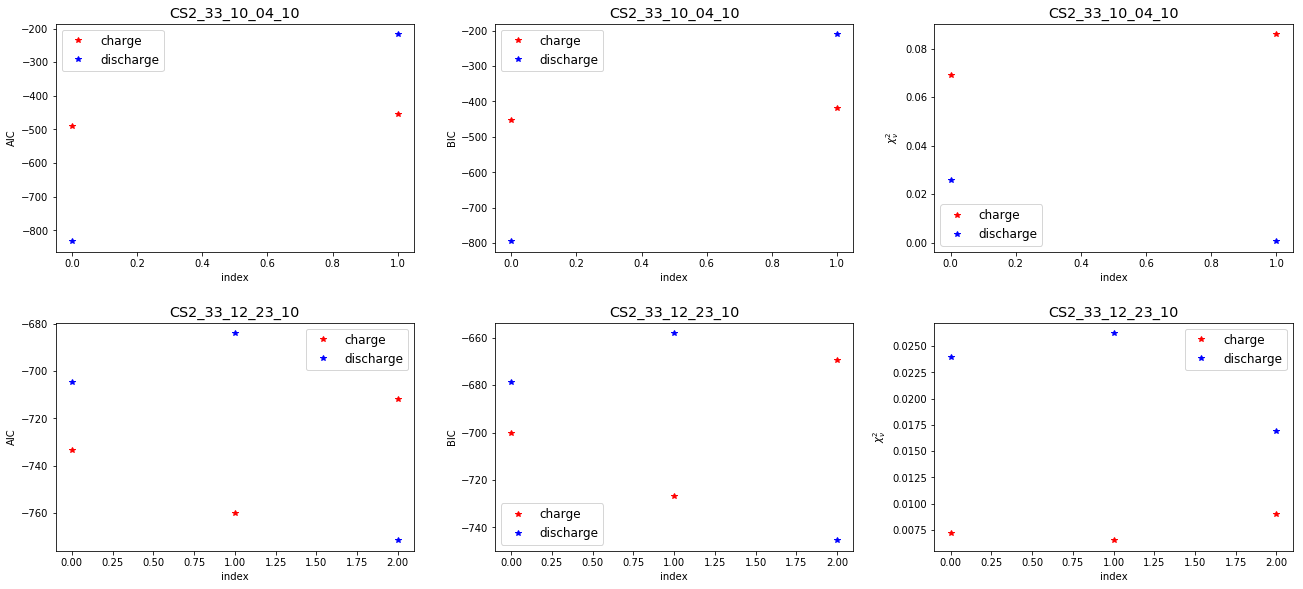

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

df = pd.read_excel('describe.xlsx')

df1 = df[df['names'].str.contains("CS2_33_10_04_10")]
df2 = df[df['names'].str.contains("CS2_33_12_23_10")]

fig, axes = plt.subplots(2, 3, figsize=(19, 9))
fig.tight_layout(pad=5)

#plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size':12})
#first and second peak location for the first battery
axes[0, 0].plot(df1.index, df1['ch_AIC'], '*r', df1.index, df1['dc_AIC'], '*b')
axes[0, 0].set_title('CS2_33_10_04_10')
axes[0, 0].set_xlabel('index')
axes[0, 0].set_ylabel('AIC')
axes[0, 0].legend(['charge', 'discharge'])

axes[0, 1].plot(df1.index, df1['ch_BIC'], '*r', df1.index, df1['dc_BIC'], '*b')
axes[0, 1].set_title('CS2_33_10_04_10')
axes[0, 1].set_xlabel('index')
axes[0, 1].set_ylabel('BIC')
axes[0, 1].legend(['charge', 'discharge'])

axes[0, 2].plot(df1.index, df1['ch_red_chi_squared'], '*r', df1.index, df1['dc_red_chi_squared'], '*b')
axes[0, 2].set_title('CS2_33_10_04_10')
axes[0, 2].set_xlabel('index')
axes[0, 2].set_ylabel(r'$\chi^{2}_{\nu}$')
axes[0, 2].legend(['charge', 'discharge'])

axes[1, 0].plot(df2.index, df2['ch_AIC'], '*r', df2.index, df2['dc_AIC'], '*b')
axes[1, 0].set_title("CS2_33_12_23_10")
axes[1, 0].set_xlabel('index')
axes[1, 0].set_ylabel('AIC')
axes[1, 0].legend(['charge', 'discharge'])

axes[1, 1].plot(df2.index, df2['ch_BIC'], '*r', df2.index, df2['dc_BIC'], '*b')
axes[1, 1].set_title("CS2_33_12_23_10")
axes[1, 1].set_xlabel('index')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].legend(['charge', 'discharge'])

axes[1, 2].plot(df2.index, df2['ch_red_chi_squared'], '*r', df2.index, df2['dc_red_chi_squared'], '*b')
axes[1, 2].set_title("CS2_33_12_23_10")
axes[1, 2].set_xlabel('index')
axes[1, 2].set_ylabel(r'$\chi^{2}_{\nu}$')
axes[1, 2].legend(['charge', 'discharge'])